# Exercise 2 - Shor's algorithm solution
**Created by:** Frank Harkins

This circuit can be constructed using a CNOT and a Toffoli. Since this part isn't graded, I didn't spend time optimising this.

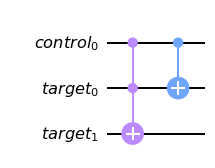

In [1]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, QuantumCircuit
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu = QuantumCircuit(c, t, name="Controlled 13^x mod 35")

# Your code goes here

# easy (non-optimal) solution:

cu.ccx(c, t[0], t[1])
cu.cx(c, t[0])

# end solution

cu.draw()

After this initial circuit, the user can complete the challenge by simply repeating the circuit a few times. For example, the next solution is just the first solution repeated twice (there is however a much simpler solution!).

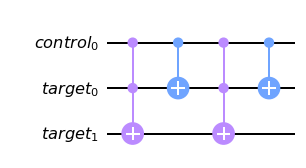

In [2]:
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu2 = QuantumCircuit(c, t)

# Your code here

# Non-optimal solution:
cu2 = cu.compose(cu)
# end solution

cu2.draw()

And you can repeat the circuit twice more to complete the third circuit. The circuit below is correct, but a _very_ inefficient solution as this circuit is the same as the identity gate (i.e. doing nothing), so an empty circuit was a valid submission here!

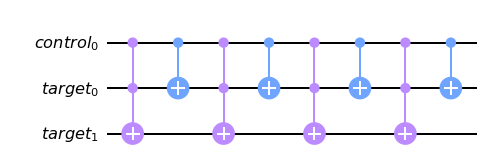

In [3]:
c = QuantumRegister(1, 'control')
t = QuantumRegister(2, 'target')
cu4 = QuantumCircuit(c, t)

# Your code here

# VERY bad solution (to be removed):
cu4 = cu2.compose(cu2)
# end solution

cu4.draw()

## Graded challenge

So we've actually already made all the components needed to complete this challenge, so we can simply plug them into the final submission. As expected, this isn't the most efficient solution; some users found solutions with only 6 CNOTs!

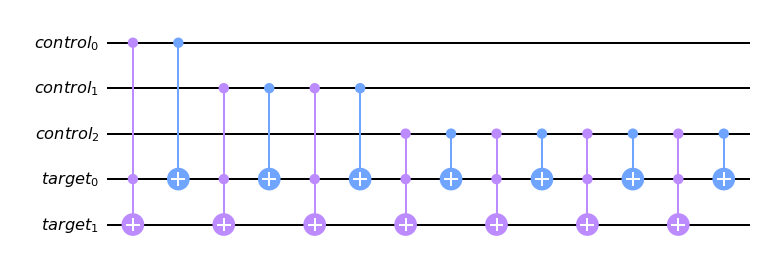

In [4]:
cqr = QuantumRegister(3, 'control')
tqr = QuantumRegister(2, 'target')
cux = QuantumCircuit(cqr, tqr)
solutions = [cu, cu2, cu4]
for i in range(3):
    cux = cux.compose(solutions[i], [cqr[i], tqr[0], tqr[1]])
cux.draw()

## Alternative approach

Below is an example of a better solution that uses Fourier transforms to get a cost of 8. I don't think this approach beats the 'standard' approach (CNOTs + Toffoli) but does give an idea of what alternative approaches could look like.

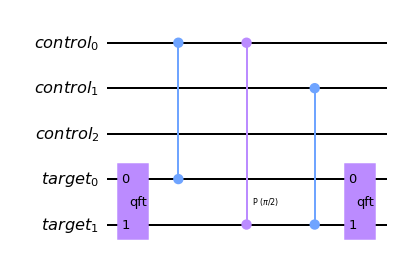

In [5]:
# To be removed before the challenge
from qiskit.circuit.library import QFT
from qiskit import transpile
import numpy as np
cqr = QuantumRegister(3, 'control')
tqr = QuantumRegister(2, 'target')
cux2 = QuantumCircuit(cqr, tqr)
cux2.append(QFT(2, do_swaps=False), [3, 4])
cux2.cz(0, 3)
cux2.cp(np.pi/2, 0, 4)
cux2.cz(1, 4)
cux2.append(QFT(2, inverse=True, do_swaps=False), [3, 4])
display(cux2.draw())

When we transpile we get the 8 CNOT solution:

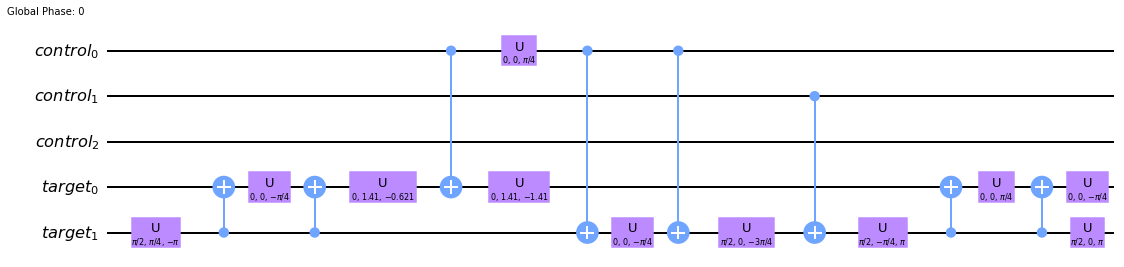

8

In [6]:
t_cux2 = transpile(cux2, basis_gates=['u','cx'], optimization_level=3)
display(t_cux2.draw())
t_cux2.count_ops()['cx']

## Demonstrate circuit on device

This is the circuit that would then be run on Athens:

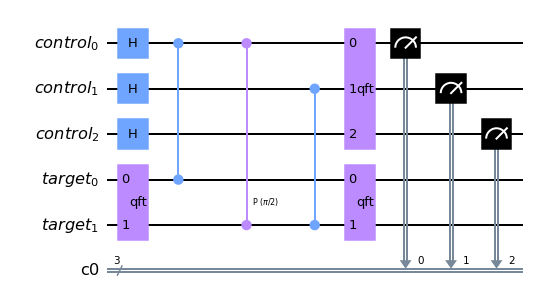

In [7]:
from qiskit.circuit.library import QFT
from qiskit import ClassicalRegister
cr = ClassicalRegister(3)
shor_circuit = QuantumCircuit(cqr, tqr, cr)
shor_circuit.h(cqr)

shor_circuit.compose(cux2, inplace=True)

shor_circuit.append(QFT(3, inverse=True, do_swaps=True), cqr)
shor_circuit.measure(cqr, cr)
shor_circuit.draw()

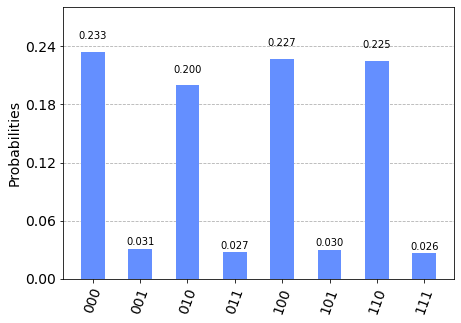

In [8]:
from qiskit.test.mock import FakeAthens
from qiskit import assemble
from qiskit.visualization import plot_histogram

# we can do some more transpiling to squeeze out extra performance, but this isn't necessary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import HoareOptimizer
athens = FakeAthens()
tqc = transpile(shor_circuit, athens, optimization_level=3)
pm = PassManager(HoareOptimizer())
tqc = pm.run(tqc)
counts = athens.run(assemble(tqc)).result().get_counts()
plot_histogram(counts)

In the results above we have a 9% chance of getting an erroneous result.